# Individual part of the IDH project

This is the Jupyter notebook for the individual part of the project for the Introduction to Digital Humanities course at KU Leuven, 2025.
The goal is to analyze various asspects of different languages appearing in the database.

## Setting up Python

In [426]:
import pandas as pd
import langdetect as ld
from iso639 import Lang
import spacy
from tabulate import tabulate
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Importing the data

In [2]:
books_df = pd.read_csv("All-merged-authors-imprint-title-clean-reconciled.csv", sep=",", low_memory=False, encoding="utf-8")

In [73]:
list(books_df)

['File',
 'Aleph system no.',
 'Country code',
 'Language code (008)',
 'Language code (041)',
 'DDC',
 'Personal-author_ORIGINAL',
 'Personal-author_clean',
 'Personal_author_clean_URL',
 'Personal_author_title',
 'Personal_author_years',
 'Personal_author_floruit',
 'Personal_author_DoB',
 'Personal_author_DoD',
 'Personal_author_pseudonym',
 'Corporate author',
 'Title_ORIGINAL',
 'Title_clean',
 'Title_clean_after_By',
 'Title_clean_language_detected',
 'Edition',
 'Imprint_ORIGINAL',
 'Location_clean',
 'Location_clean_URL',
 'Date',
 'Location_intermediate',
 'Series',
 'Subjects',
 'Other personal authors',
 'Other corporate authors',
 'DOM ID',
 'Type',
 'Genre',
 'Column',
 'py-lang-det']

## Exploring languages

We have three columns which can tell us something about language in the database. We first add a fourth column, using `langdetect` module. We will iterate through the `Title_clean`column and use it to detect the language of the title. Seeing as `langdetect` is non deterministic (which can become obvious when used on short strings), we will first make small adjustements to get consistent results.

In [245]:
# Setting seed to get consistent results
from langdetect import DetectorFactory
DetectorFactory.seed = 1984

In [246]:
langlist_ld = []
# Iterate through book titles and detect language for every title
for i, t in books_df['Title_clean'].items():
    try:
        langlist_ld.append(ld.detect(t))
    except:
        langlist_ld.append("Error")
        print (f"The title'{t}' at index '{i}' has error.")

The title']' at index '3609' has error.
The title'nan' at index '3928' has error.
The title'nan' at index '4428' has error.
The title'nan' at index '4954' has error.
The title'nan' at index '7079' has error.
The title'nan' at index '8321' has error.
The title'nan' at index '8631' has error.
The title'nan' at index '9601' has error.
The title'nan' at index '10140' has error.
The title'.' at index '10404' has error.
The title'nan' at index '12381' has error.
The title'nan' at index '13276' has error.
The title'nan' at index '13380' has error.
The title'nan' at index '13388' has error.
The title'nan' at index '14156' has error.
The title'nan' at index '14322' has error.
The title'nan' at index '14720' has error.
The title'nan' at index '15159' has error.
The title'nan' at index '16727' has error.
The title'nan' at index '20576' has error.
The title'"' at index '24542' has error.
The title'nan' at index '25380' has error.
The title'nan' at index '25901' has error.
The title'"' at index '26

In [247]:
# Count the number of errors while langugae detecting 
langlist_ld.count("Error")

67

In [248]:
# Insert the new list of detected languages as a column to the DF.
books_df["py-lang-det"] = langlist_ld

We now have four columns. First two columns, `Language code (008)` and `(041)` contain information on the language of the book itself, not of the title. In addition, the `(041)` column has considerably less data than other columns which will make it harder to compare it with the other three. 

In [252]:
count041 = books_df['Language code (041)'].count()
print(f"There are {count041} non-zero values in the 'Language code (041)' column, which is about {round(count041/len(books_df['Language code (041)'])*100, 2)}% of all rows.")

There are 596 non-zero values in the 'Language code (041)' column, which is about 1.21% of all rows.


The other two columns gives us information on language detection of the titles. The `Title_clean_language_detected` column was made using the Google API, while the `py-lang-det` column contains data generate by the module in the code above.

Let's perform some basic descriptive statistics on these three.

In [169]:
# Assign the three remaining columns of interest to their variables
langs_google = books_df['Title_clean_language_detected']
langs_py = books_df['py-lang-det']
langs_data = books_df['Language code (008)']

In [217]:
# Count number of non-empty values in columns and count unique values (i.e. recognized languaes)
lang_df_info = [
    ['Google', langs_google.count(), langs_google.nunique()],
    ['Python', langs_py.count(), langs_py.nunique()],
    ['Data', langs_data.count(), langs_data.nunique()]
]
ldi_head = ['Tool', 'Total len', 'uniques']
print(tabulate(lang_df_info, headers=ldi_head, tablefmt="grid"))

+--------+-------------+-----------+
| Tool   |   Total len |   uniques |
+========+=============+===========+
| Google |       49455 |       105 |
+--------+-------------+-----------+
| Python |       49455 |        38 |
+--------+-------------+-----------+
| Data   |       49455 |        28 |
+--------+-------------+-----------+


We can see that these columns greatly differ one from another. Let's inspect which languages do they report as the most frequent.

In [184]:
langs_google.value_counts(normalize = True)[0:6]

Title_clean_language_detected
eng    0.750763
fre    0.081953
ger    0.068648
ita    0.015529
spa    0.015347
dut    0.011950
rus    0.008493
Name: proportion, dtype: float64

In [185]:
langs_py.value_counts(normalize = True)[0:6]

py-lang-det
en    0.717561
fr    0.086179
de    0.075827
it    0.019674
nl    0.017369
es    0.016217
Name: proportion, dtype: float64

In [186]:
langs_data.value_counts(normalize = True)[0:6]

Language code (008)
eng    0.389243
und    0.381701
fre    0.077505
ger    0.063917
spa    0.015549
ita    0.012981
Name: proportion, dtype: float64

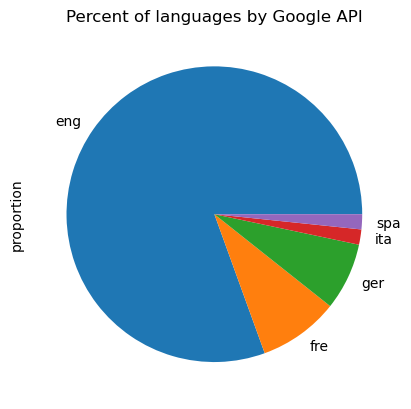

In [235]:
# Make charts out of these
lang_google_plot = langs_google.value_counts(normalize = True)[0:5].plot(kind='pie', title = "Percent of languages by Google API")

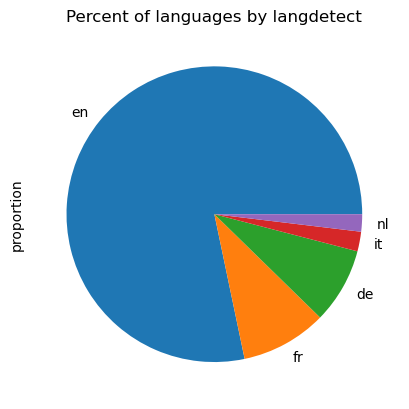

In [236]:
lang_py_plot = langs_py.value_counts(normalize = True)[0:5].plot(kind='pie', title = "Percent of languages by langdetect")

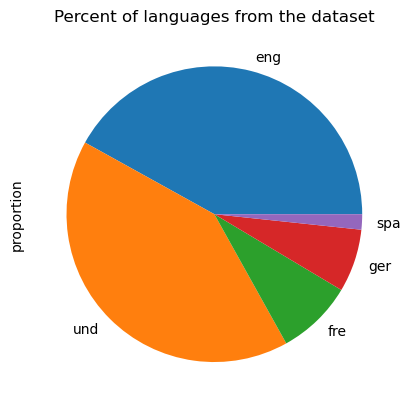

In [237]:
lang_data_plot = langs_data.value_counts(normalize = True)[0:5].plot(kind='pie', title = "Percent of languages from the dataset")

In [240]:
lang_google_plot.figure.savefig('lang-google-perc.jpg')
lang_py_plot.figure.savefig('lang-py-perc.jpg')
lang_data_plot.figure.savefig('lang-data-perc.jpg')

## Languages ~ Genre

Before moving on to topic analysis, let's see the distribution of different genres for English, French and German. Genre is usually closely correlated to the topic of a book so it will be useful to compare this to the topic modeling results.

In [385]:
pd.crosstab(books_df['py-lang-det'].loc[books_df['py-lang-det'] == "en"],
            books_df['Genre'], 
            normalize =True)

Genre,Drama,Music,Poetry,Prose
py-lang-det,,,,
en,0.092403,0.050824,0.303534,0.553239


In [387]:
pd.crosstab(books_df['py-lang-det'].loc[books_df['py-lang-det'] == "fr"],
            books_df['Genre'], 
            normalize =True)

Genre,Drama,Music,Poetry,Prose
py-lang-det,,,,
fr,0.034483,0.01061,0.525199,0.429708


In [418]:
pd.crosstab(books_df['py-lang-det'].loc[books_df['py-lang-det'] == "de"],
            books_df['Genre'], 
            normalize =True)

Genre,Drama,Music,Poetry,Prose
py-lang-det,,,,
de,0.013928,0.041783,0.632312,0.311978


**NOTA BENE**: We must be careful when interpreting these results, because the large majority of books comes from the 'nongenre' collection and thus lacks a genre value. 

In [420]:
books_df.groupby("File")['File'].value_counts()

File
drama.xlsx       1647
music.xlsx        936
nogenre.xlsx    30146
poetry.xls      16726
Name: count, dtype: int64

### Title length by genre

The length of titles in each genre will also be important for our analysis and comparison. For that reason we will extract the length of each title and add it to our dataframe. We will then see the average length in general and for each genre.

In [389]:
nlp_titles = spacy.load("en_core_web_sm", disable=['ner', 'tagger', 'parser', 'textcat'])

In [405]:
titles_len = []
for t in books_df['Title_clean']:
    try:
        title_tokens = []
        t_nlp = nlp_titles(t)
        for token in t_nlp:
            title_tokens.append(token)
        titles_len.append(len(title_tokens))
    except:
        titles_len.append(1)

C:\Users\Pero\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [410]:
books_df['Title_length'] = titles_len

In [409]:
print (f'The average title is around {round(sum(titles_len)/len(titles_len), 2)} tokens long')

The average title is around 15.48 tokens long


In [411]:
books_df.groupby("Genre")['Title_length'].mean()

Genre
Drama     14.647845
Music     19.047959
Poetry    15.292358
Prose     12.834030
Name: Title_length, dtype: float64

## Analyzing the titles

Having in mind all that we saw above, we will use the `lang-py-det` column to detect language of the title. We will perform topic analysis on English, French and German, because they have enough titles to gather sensible data.

For this purpse we will use `spaCy` to preprocess the titles (it has a good support for all these three languages) and `Gensim` to perform the topic modelling.

The whole process was heavily based on and inspired by the online tutorial on topic modelling, [*Topic Modeling with Python (Gensim & SpaCy)*](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html), a part of the *Exploring Themes with Topic Modeling* workshop from a series of workshops on computational text analysis by [*The Sherman Centre for Digital Scholarship*](https://scds.ca/).

An important change in respect to the tutorial above is that we do not use the [LDA model](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0/), but opt for the [NMF](https://medium.com/@sophiamsac/understanding-nmf-for-simple-topic-modelling-b3d7bc4f3fc2), inspired by [this article](https://medium.com/@vlad.andreichuk/non-negative-matrix-factorization-nmf-for-the-grouping-of-articles-titles-a73e654b6244) (and some very bad results using LDA).

### English

First we will preprocess titles using SpaCy and Genism. We are using the `en_core_web_lg` model. We extract the titles and use functions (taken from the [tutorial](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html)).

In [263]:
# Extract the English titles, based on the 'py-lang-det' column, the one we created using langdetect
en_titles = books_df['Title_clean'].loc[books_df["py-lang-det"] == "en"]

In [ ]:
# Load the nlp pipeline, omitting the parser and ner steps of the workflow to conserve computer memory
nlp_en = spacy.load("en_core_web_lg", disable=["parser", "ner"])

In [283]:
print(f'Based on our languages detection, there are {len(en_titles)} English titles.')

Based on our languages detection, there are 35442 English titles.


We will first define the [lemmatization function](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html#step5). It takes the texts (in our case the titles), and lemmatizes them, skiping function words (see `allowed_postags`) and certain lemmas (see `forbidden_lemmas`). The lemmas to skip were chosen after initial testings to get better results in topic modelling. 

After lemmatization, we perform [additional processing](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html#step5), basically using Gensim's `simple_preprocess` to remove accents and get better formed tokens.

In [298]:
def lemmatization_en (texts, 
                  allowed_postags=["NOUN", "ADJ", "VERB", "ADV"], 
                  forbidden_lemmas=['edit', 'edition', 'second', 'third', 'illustrate', 'illustrated', 'illustration']):   
    # Doing part of speech (PoS) tagging helps with lemmatization
    texts_out = []
    for text in texts: # Run each of the documents through the nlp pipeline
        doc = nlp_en(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.lemma_ not in forbidden_lemmas:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [297]:
en_lemmatized_texts = lemmatization_en(en_titles)

In [63]:
def gen_words(texts):
    final = [] # Create an empty list to hold tokens
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = True) 
        # If working with languages that employ accents, you can set deacc to False
        final.append(new)
    return (final)

In [299]:
en_data_words = gen_words(en_lemmatized_texts)

Still following the tutorial, we form bigrams and trigram from frequently occuring phrases. While this is maybe not as necessary for our short book titles, it can be useful. 

In [301]:
en_bigram_phrases = gensim.models.Phrases(en_data_words, min_count=3, threshold=50)
en_trigram_phrases = gensim.models.Phrases(en_bigram_phrases[data_words], threshold=50)

en_bigram = gensim.models.phrases.Phraser(en_bigram_phrases)
en_trigram = gensim.models.phrases.Phraser(en_trigram_phrases)

def make_bigrams(texts):
    return [en_bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [en_trigram[bigram[doc]] for doc in texts]

en_data_bigrams = make_bigrams(en_data_words)
en_data_bigrams_trigrams = make_trigrams(en_data_bigrams)

Next, we [build a dictionary](https://learn.scds.ca/text-analysis-3/lessons/tmpython.html#step8) from the processed data, where we the key is a unique identifier of each word appearing in our titles and the value is number of counts/occurences of each of these word.

Here we diverge from the tutorial and add an additional step to the process - we transform the terms in the dictionary using the TF-IDF model to get better result in the NMF analysis later.

In [302]:
# Create dictionary of all words in texts
en_id2word = corpora.Dictionary(en_data_bigrams_trigrams)

# Represent dictionary words as tuples (index, frequency)
en_corpus = []
for text in en_data_bigrams_trigrams:
    new = en_id2word.doc2bow(text)
    en_corpus.append(new)

en_tfidf = gensim.models.TfidfModel(en_corpus)
en_corpus_tfidf = en_tfidf[en_corpus]

We finally implement the NMF model.

In [341]:
# Create NMF model
en_nmf_model = gensim.models.nmf.Nmf(corpus=en_corpus_tfidf,
                                            id2word=en_id2word,
                                            num_topics=7,
                                            random_state = 1986,
                                            chunksize=3000,     
                                            # Change chunksize to increase or decrease the length of segments
                                            passes=100,         
                                            # Can do more passes but will increase the time it takes the block to run
                                            kappa=0.1)

# Print topics
en_nmf_model.show_topics()

[(0,
  '0.060*"comedy" + 0.040*"map" + 0.038*"new" + 0.013*"revise" + 0.012*"life" + 0.011*"account" + 0.009*"year" + 0.008*"author" + 0.006*"letter" + 0.006*"guide"'),
 (1,
  '0.460*"story" + 0.079*"other" + 0.058*"life" + 0.027*"love" + 0.013*"day" + 0.009*"modern" + 0.008*"author" + 0.007*"australian" + 0.006*"true" + 0.006*"adventure"'),
 (2,
  '0.449*"poem" + 0.218*"other" + 0.014*"canto" + 0.010*"several_occasion" + 0.008*"various_subject" + 0.008*"verse" + 0.007*"book" + 0.005*"piece" + 0.005*"song" + 0.004*"sonnet"'),
 (3,
  '0.457*"history" + 0.042*"note" + 0.017*"early" + 0.009*"time" + 0.009*"introduction" + 0.009*"biographical" + 0.008*"antiquity" + 0.008*"county" + 0.008*"town" + 0.008*"present"'),
 (4,
  '0.277*"tale" + 0.075*"romance" + 0.053*"translate" + 0.025*"day" + 0.017*"historical" + 0.014*"letter" + 0.009*"last" + 0.009*"time" + 0.008*"original" + 0.008*"song"'),
 (5,
  '0.781*"novel" + 0.006*"wife" + 0.005*"daughter" + 0.003*"only" + 0.002*"secret" + 0.002*"love

In [427]:
en_topics = en_nmf_model.show_topics()

In [424]:
CoherenceModel(
    model=en_nmf_model,
    corpus=en_corpus_tfidf,
    coherence='u_mass'
).get_coherence()

np.float64(-8.842513710893977)

In [429]:
vis_data = gensimvis.prepare(en_nmf_model, en_corpus_tfidf, en_id2word, R=15, mds='mmds')
vis_data
pyLDAvis.display(vis_data)
#pyLDAvis.save_html(vis_data, './topicVis' + str(num_topics) + '.html')

C:\Users\Pero\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\Pero\anaconda3\Lib\ast.py:602: DeprecationWarning: Constant.__init__ got an unexpected keyword argument 's'. Support for arbitrary keyword arguments is deprecated and will be removed in Python 3.15.
  return Constant(*args, **kwargs)
C:\Users\Pero\anaconda3\Lib\ast.py:602: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
C:\Users\Pero\anaconda3\Lib\ast.py:602: DeprecationWarning: Constant.__init__ missing 1 required positional argument: 'value'. This will become an error in Python 3.15.
  return Constant(*args, **kwargs)
C:\Users\Pero\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  r

AttributeError: 'Nmf' object has no attribute 'inference'

### German

In [294]:
de_titles = books_df['Title_clean'].loc[books_df["py-lang-det"] == "de"]

In [344]:
nlp_de = spacy.load("de_core_news_lg", disable=["parser", "ner"])

ERROR! Session/line number was not unique in database. History logging moved to new session 223


In [328]:
def lemmatization_de (texts, 
                  allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):   
    # Doing part of speech (PoS) tagging helps with lemmatization
    texts_out = []
    for text in texts: # Run each of the documents through the nlp pipeline
        doc = nlp_de(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.lemma_ != "etc.":
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [329]:
de_lemmatized_texts = lemmatization_de(de_titles)

In [335]:
def gen_words_defr(texts):
    final = [] # Create an empty list to hold tokens
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = False) 
        # If working with languages that employ accents, you can set deacc to False
        final.append(new)
    return (final)

In [336]:
de_data_words = gen_words_defr(de_lemmatized_texts)

In [337]:
de_bigram_phrases = gensim.models.Phrases(de_data_words, min_count=3, threshold=50)
de_trigram_phrases = gensim.models.Phrases(de_bigram_phrases[data_words], threshold=50)

de_bigram = gensim.models.phrases.Phraser(de_bigram_phrases)
de_trigram = gensim.models.phrases.Phraser(de_trigram_phrases)

def make_bigrams(texts):
    return [de_bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [de_trigram[bigram[doc]] for doc in texts]

de_data_bigrams = make_bigrams(de_data_words)
de_data_bigrams_trigrams = make_trigrams(de_data_bigrams)

In [338]:
# Create dictionary of all words in texts
de_id2word = corpora.Dictionary(de_data_bigrams_trigrams)

# Represent dictionary words as tuples (index, frequency)
de_corpus = []
for text in de_data_bigrams_trigrams:
    new = de_id2word.doc2bow(text)
    de_corpus.append(new)

de_tfidf = gensim.models.TfidfModel(de_corpus)
de_corpus_tfidf = de_tfidf[de_corpus]

In [342]:
# Create NMF model
de_nmf_model = gensim.models.nmf.Nmf(corpus=de_corpus_tfidf,
                                            id2word=de_id2word,
                                            num_topics=7,
                                            random_state = 1986,
                                            chunksize=3000,     
                                            # Change chunksize to increase or decrease the length of segments
                                            passes=100,         
                                            # Can do more passes but will increase the time it takes the block to run
                                            kappa=0.1)

# Print topics
de_nmf_model.show_topics()

[(0,
  '0.160*"deutsch" + 0.032*"volk" + 0.022*"jahrhundert" + 0.020*"reich" + 0.019*"mittelalter" + 0.015*"krieg" + 0.014*"zweiter" + 0.013*"auflage" + 0.013*"ausgabe" + 0.012*"erinnerung"'),
 (1,
  '0.328*"geschichte" + 0.023*"quelle" + 0.014*"preussisch" + 0.013*"alterthum" + 0.012*"volk" + 0.011*"land" + 0.011*"bd" + 0.010*"zeit" + 0.010*"allgemein" + 0.007*"deutsche"'),
 (2,
  '0.043*"historisch" + 0.042*"alt" + 0.027*"beschreibung" + 0.019*"land" + 0.015*"geographisch" + 0.014*"skizze" + 0.012*"topographisch" + 0.012*"statistisch" + 0.010*"gegenwart" + 0.010*"französisch"'),
 (3,
  '0.421*"stadt" + 0.061*"chronik" + 0.017*"verfassung" + 0.013*"quelle" + 0.011*"festschrift" + 0.008*"urkundliche" + 0.007*"archiv" + 0.007*"urkunde" + 0.007*"frei" + 0.007*"ursprung"'),
 (4,
  '0.127*"beitrag" + 0.082*"bild" + 0.021*"studie" + 0.014*"herausgeben" + 0.014*"krieg" + 0.012*"vergangenheit" + 0.010*"denkwürdigkeit" + 0.009*"vorzeit" + 0.009*"bauernkrieg" + 0.008*"urkunde"'),
 (5,
  '0.101*

### French

In [343]:
fr_titles = books_df['Title_clean'].loc[books_df["py-lang-det"] == "fr"]

In [345]:
nlp_fr = spacy.load("fr_core_news_lg", disable=["parser", "ner"])

In [356]:
def lemmatization_fr (texts, 
                  allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):   
    # Doing part of speech (PoS) tagging helps with lemmatization
    texts_out = []
    for text in texts: # Run each of the documents through the nlp pipeline
        doc = nlp_fr(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.lemma_ not in ["etc.", "publier", "édition"]:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [357]:
fr_lemmatized_texts = lemmatization_fr(fr_titles)

In [358]:
fr_data_words = gen_words_defr(fr_lemmatized_texts)

In [359]:
fr_bigram_phrases = gensim.models.Phrases(fr_data_words, min_count=3, threshold=50)
fr_trigram_phrases = gensim.models.Phrases(fr_bigram_phrases[data_words], threshold=50)

fr_bigram = gensim.models.phrases.Phraser(fr_bigram_phrases)
fr_trigram = gensim.models.phrases.Phraser(fr_trigram_phrases)

def make_bigrams(texts):
    return [fr_bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [fr_trigram[bigram[doc]] for doc in texts]

fr_data_bigrams = make_bigrams(fr_data_words)
fr_data_bigrams_trigrams = make_trigrams(fr_data_bigrams)

In [360]:
# Create dictionary of all words in texts
fr_id2word = corpora.Dictionary(fr_data_bigrams_trigrams)

# Represent dictionary words as tuples (index, frequency)
fr_corpus = []
for text in fr_data_bigrams_trigrams:
    new = fr_id2word.doc2bow(text)
    fr_corpus.append(new)

fr_tfidf = gensim.models.TfidfModel(fr_corpus)
fr_corpus_tfidf = fr_tfidf[fr_corpus]

In [361]:
# Create NMF model
fr_nmf_model = gensim.models.nmf.Nmf(corpus=fr_corpus_tfidf,
                                            id2word=fr_id2word,
                                            num_topics=7,
                                            random_state = 1986,
                                            chunksize=3000,     
                                            # Change chunksize to increase or decrease the length of segments
                                            passes=100,         
                                            # Can do more passes but will increase the time it takes the block to run
                                            kappa=0.1)

# Print topics
fr_nmf_model.show_topics()

[(0,
  '0.306*"voyage" + 0.037*"travers" + 0.034*"impression" + 0.033*"lettre" + 0.024*"journal" + 0.021*"note" + 0.021*"récit" + 0.020*"an" + 0.016*"année" + 0.016*"illustration"'),
 (1,
  '0.121*"historique" + 0.049*"étude" + 0.041*"recherche" + 0.034*"notice" + 0.029*"statistique" + 0.026*"archéologique" + 0.023*"description" + 0.023*"pittoresque" + 0.017*"département" + 0.016*"essai"'),
 (2,
  '0.080*"ouvrage" + 0.074*"carte" + 0.070*"illustrer" + 0.069*"gravure" + 0.027*"contenir" + 0.021*"orner" + 0.021*"accompagner" + 0.019*"plan" + 0.017*"dessin" + 0.016*"note"'),
 (3,
  '0.190*"révolution" + 0.150*"histoire" + 0.103*"français" + 0.023*"illustration" + 0.019*"république" + 0.019*"politique" + 0.014*"étude" + 0.012*"troisième" + 0.010*"empire" + 0.010*"belge"'),
 (4,
  '0.225*"histoire" + 0.200*"ville" + 0.030*"ancien" + 0.027*"origine" + 0.013*"mémoire" + 0.012*"servir" + 0.012*"province" + 0.010*"archive" + 0.009*"institution" + 0.009*"temps_plus"'),
 (5,
  '0.090*"souvenir" +